Sequencing and Sketching, A Rate Distortion Perspective: Implementation

In [1]:
import numpy as np
import random
import math
import matplotlib as mpl
import matplotlib.pyplot as plt

MinHash (MHAP) implementation

In [2]:
# Problem setup
numHashes = 100; #The number of Hash functions we introduce
n = 1000 #Size of each $X_1$ and $X_2$
theta = 0.1 #fraction of overlap (We need to estimate this)
stringSize = int((2-theta)*n) #The length of $X$
string2_start = int((1-theta)*n) #Starting point of $X_2$
TotalStringsGenerated = 10 #Number Of Strings $X$ we generate

In [3]:
# Generate sequences to estimate the rate-distortion pair later
string_set = []; #Array that holds $TotalStringsGenerated$ number of strings of length $(2-\theta)n$
string1_set = []; #Array that holds first extracted of string of size n
string2_set = []; #Array that holds second extracted of string of size n
for i in range(TotalStringsGenerated): #Creates random $Bern(1/2)$ strings $(X's)$ and extracts $X_1$ and $X_2$ from them
    string = np.random.binomial(size = stringSize,n=1,p=0.5);
    string =''.join(map(str, string));
    string1 = string[0:n];
    string2 = string[string2_start:stringSize];
    string_set.append(string);
    string1_set.append(string1);
    string2_set.append(string2);

In [4]:
# Function to obtain kmers from string
def ObtainKmerSet(string,subStringSize): # Takes input as the any string (with arbitrary alphabet) (need to use "")
    if(len(string)-subStringSize+1 <= 0):
        print("invalid length allotment") #kmer size cannot be greater than string size
        return
    else:
        counts = {}; #Dictionary holding the kmers, without repititions
        for i in range(len(string)-subStringSize+1):
            kmer = string[i:i+subStringSize] #Extract the kmer
            if kmer not in counts: #Adds kmer as dict index if it doesn't exist before
                counts[kmer] = 0;
            counts[kmer] += 1; #Adds an extra count to these kmers
    return counts

The next set of functions will be used to obtain the sketches of kmers \
We use a random hash function of the form $(a*dec(kmer) + b) \mod c$, where the $a,b$ are random numbers and $c$ is a prime number above the highest possible hash output. \
For a reasonable $k$, say not greater than $32$, when we focus on the binary case, a prime number above $2^{32}$ is good enough

In [5]:
#Function that generates random coefficients for the hash function (we will use $m$ hash functions)
def RandomCoefficients(numHashFunctions,maxSketch):
    randList = np.array([]); #Contains the $numHashFunctions$ random integers
    while numHashFunctions > 0:
        randInt = random.randint(0,maxSketch); #Get a random number
        if randInt in randList:
            randInt = random.randint(0,maxSketch); #Make sure the number doesn't repeat
        randList = np.append(randList,randInt)
        numHashFunctions -= 1;
    return randList

In [6]:
def isPrime(n):
     
    # Corner cases
    if(n <= 1):
        return False
    if(n <= 3):
        return True
     
    # This is checked so that we can skip
    # middle five numbers in below loop
    if(n % 2 == 0 or n % 3 == 0):
        return False
     
    for i in range(5,int(math.sqrt(n) + 1), 6):
        if(n % i == 0 or n % (i + 2) == 0):
            return False
     
    return True
 
# Function to return the smallest
# prime number greater than N
def nextPrime(N):
 
    # Base case
    if (N <= 1):
        return 2
 
    prime = N
    found = False
 
    # Loop continuously until isPrime returns
    # True for a number greater than n
    while(not found):
        prime = prime + 1
 
        if(isPrime(prime) == True):
            found = True
 
    return prime

In [7]:
# Function that applies random hash functions to a dictionary of kmers
def HashFunctionOfKmers(kmerDict,maxSketch,numHashFunctions,c,CoeffA,CoeffB): #Takes input as a dictionary of kmers and the maximun sketch value
    Sketches = np.array([]);  
    for i in range(0, numHashFunctions): #Compute by iterating over number of hash functions
        minHash = c + 1;
        for kmer in kmerDict: #
            hashCode = (CoeffA[i]*int(kmer,2) + CoeffB[i])%c #Evaluate hash of kmer
            if hashCode < minHash:
                minHash = hashCode;
        Sketches = np.append(Sketches,minHash)
    return Sketches

In [8]:
#Calculating rates and functions
k = int(3*np.log2(n)) # Parameter: Given a $k$, we work on the $n-k+1$ substrings of $X_i$ (kmers). We fix k to be $3\log{n}$ for now
substringNumber = (n-k+1)#Total number of substrings generated for a given $n$ and $k$
#maxSketch = 2**16 #Highest Value assigned by hash function, implies B is just \log(maxSketch)

In [9]:
#Obtain set of kmer dictionaries
Sketch1_setkmer = [];#Set of dictionaries containing kmers of each string1
Sketch2_setkmer = [];#Set of dictionaries containing kmers of each string2
for i in range(TotalStringsGenerated):    
    temp1 = ObtainKmerSet(string1_set[i],k);
    Sketch1_setkmer.append(temp1);
    temp2 = ObtainKmerSet(string2_set[i],k);
    Sketch2_setkmer.append(temp2);

In [10]:
# Calculate rate distortion pairs for all strings, by varying rate B.

def DistortionForRate(maxSketch,Sketch1_setkmer,Sketch2_setkmer):
    CoeffA = RandomCoefficients(numHashes,2**maxSketch); #First pick the random coefficients for the hash functions
    CoeffB = RandomCoefficients(numHashes,2**maxSketch);
    c = nextPrime(maxSketch) #Lowest prime greater than maxSketchValue
    Sketch1 = HashFunctionOfKmers(Sketch1_setkmer,maxSketch,numHashes,c,CoeffA,CoeffB) #Calculate sketches for each kmer set
    Sketch2 = HashFunctionOfKmers(Sketch2_setkmer,maxSketch,numHashes,c,CoeffA,CoeffB)
    alpha = (Sketch1 == Sketch2).sum()/(numHashes) #alpha as defined in the paper
    theta_hat = (2*alpha)/(1+alpha) #Estimate of theta
    Distortion = (theta - theta_hat)**2 #Squared distortion metric
    Rate_DistortionPair = (maxSketch,Distortion) #Rate-Distortion pair (B,D)
    return Rate_DistortionPair

In [11]:
# Rate_DistortionPair_stringset = []
# for i in range(0,1000): #Max rate B in the range
#     Rate_DistortionPair_set = []
#     for j in range(TotalStringsGenerated): #For each string
#         Rate_DistortionPair_set.append(DistortionForRate(i,Sketch1_setkmer[j],Sketch2_setkmer[j]));
#     Rate_DistortionPair_stringset.append(Rate_DistortionPair_set);

In [12]:
Rate_DistortionPair_stringset = []
for j in range(TotalStringsGenerated): #For each string
    Rate_DistortionPair_set = []
    for i in range(1000): #Max rate B in the range 
        Rate_DistortionPair_set.append(DistortionForRate(i,Sketch1_setkmer[j],Sketch2_setkmer[j]));
    Rate_DistortionPair_stringset.append(Rate_DistortionPair_set);
    print("yo")

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo


In [13]:
# Rate_DistortionPair_set = []
# for i in range(1000): #Max rate B in the range
#     Rate_DistortionPair_set.append(DistortionForRate(i,Sketch1_setkmer[0],Sketch2_setkmer[0]));
#     print("yo")

In [14]:
AvgRate_DistortionPair_set = np.mean(Rate_DistortionPair_stringset,axis=0)

In [15]:
yy = [x[0] for x in AvgRate_DistortionPair_set]

In [16]:
xx = [x[1] for x in AvgRate_DistortionPair_set]

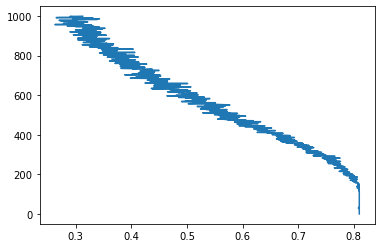

In [17]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot(xx,yy);  # Plot some data on the axes.

In [ ]:
#Change with $n$
